In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import pandas as pd
!pip install torchmetrics
!pip install torchmetrics[detection]
!pip install torchvision
# !pip install 'ray[tune]'
# !pip install -U 'ray[default]'
# !pip install -U ipywidgets
# !pip install optuna
# !pip install pycocotools
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 18.2 MB/s eta 0:00:00


# Preparing Data

In [3]:
import os

X_annot = []
for dirname, _, filenames in os.walk('/kaggle/input/camvid/CamVid/train'):
    for filename in filenames:
        X_annot.append(filename)
        
        
X_annot = pd.Series(X_annot)      
y_annot = pd.Series(list(map(lambda d: d.split(".")[0]+"_L."+d.split(".")[1],X_annot)))

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
labels=pd.read_csv("/kaggle/input/camvid/CamVid/class_dict.csv").reset_index().set_index(["r","g",'b'])
def process_y(img):
    mm = img.permute(1, 2, 0).numpy().astype("int")
    print(mm.shape)
    dest=torch.zeros((32,mm.shape[0], mm.shape[1]))

    layer=labels.loc[list(mm.reshape(-1,3))]["index"].values
    layer = layer.reshape((mm.shape[0], mm.shape[1]))
    for y in range(mm.shape[0]):
        for x in range(mm.shape[1]):
            dest[layer[y][x]][y][x] = 1
    return dest

In [6]:
def collate(batch):
    data_x = []
    data_y = []
    for i in range(len(batch)):
        data_x.append(batch[i][0])
        data_y.append(batch[i][1])
    return data_x,data_y

In [7]:
import  os
import pandas as pd
from torchvision.io import read_image
from matplotlib import pyplot as plt
from torchvision.utils import save_image

try:
    os.makedirs("/kaggle/working/transformed_images/valid/")
except:
    print("DIR exists")
class ProcessImageDataSet(torch.utils.data.Dataset):
    def __init__(self, annotations,y_annotations, img_dir,y_label_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.y_label_dir = y_label_dir
        self.annotations = annotations
        self.y_annotations = y_annotations
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx])
        y_path = os.path.join(self.y_label_dir, self.y_annotations.iloc[idx])
        image_x =  read_image(img_path) / 255
        image_y =  read_image(y_path)
        
        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)
        pt = "/kaggle/working/transformed_images/train/" + self.y_annotations.iloc[idx]
        try:
            torch.save(image_y.type(torch.ByteTensor),pt)
        except:
            print("ERROR EXISTS !")
        return image_x, image_y.double()

In [8]:
import  os
import pandas as pd
from torchvision.io import read_image
from matplotlib import pyplot as plt
from torchvision.utils import save_image

try:
    os.makedirs("/kaggle/working/transformed_images/valid/")
except:
    print("DIR exists")
class LocalCarImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations,y_annotations, img_dir,y_label_dir,x_transform=None ,transform=None, target_transform=None):
        self.img_dir = img_dir
        self.y_label_dir = y_label_dir
        self.annotations = annotations
        self.y_annotations = y_annotations
        self.transform = transform
        self.target_transform = target_transform
        self.x_transform  = x_transform 
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx])
        y_path = os.path.join(self.y_label_dir, self.y_annotations.iloc[idx])
        image_x =  read_image(img_path) / 255
        image_y =  torch.load(y_path)
        

        
        image_x,image_y = image_x.permute(1,2,0),image_y.permute(1,2,0)
        if(self.x_transform != None):
            transformed = self.x_transform(image=image_x.numpy())
            image_x = torch.from_numpy(transformed['image'])
        if(self.transform != None):
            transformed = self.transform(image=image_x.numpy(), mask=image_y.numpy())
            image_x = torch.from_numpy(transformed['image'])
            image_y = torch.from_numpy(transformed['mask'])
            
   
        image_x,image_y = image_x.permute(2,0,1),image_y.permute(2,0,1)
        
        norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        image_x = norm(image_x)
        return image_x.to("cpu"), image_y.double().to("cpu")

DIR exists


In [9]:
import torchvision.transforms as transforms

import albumentations as A
x_transform = A.Compose([
#     A.RandomCrop(width=650, height=800),
    A.RandomBrightnessContrast(p=0.5),
    A.GridDistortion(p=0.5),
    A.Downscale(p=0.5)
])
transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.Rotate(30,p=0.3)
],is_check_shapes=False)

train_dataset = LocalCarImageDataset(X_annot,y_annot,"/kaggle/input/camvid/CamVid/train", "/kaggle/working/transformed_images/train",x_transform=x_transform,transform=transform)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1692: UserWarning: Using default interpolation INTER_NEAREST, which is sub-optimal.Please specify interpolation mode for downscale and upscale explicitly.For additional information see this PR https://github.com/albumentations-team/albumentations/pull/584
  warnings.warn(


In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,batch_size=11,shuffle=True,collate_fn = collate)


In [11]:
labels=pd.read_csv("/kaggle/input/camvid/CamVid/class_dict.csv").reset_index().set_index(["r","g",'b'])
def process_y(img):
    mm = (img_y*255).permute(1, 2, 0).numpy().astype("int")
    layer=labels.loc[list(mm.reshape(-1,3))]["index"].values
    
    # Create a mask for each color
    masks = [layer == i for i in range(32)]
    
    dest=torch.tensor(masks).view((32,mm.shape[0],mm.shape[1]))
    return dest

In [12]:
train_gen = iter(train_loader)
a = next(train_gen)

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


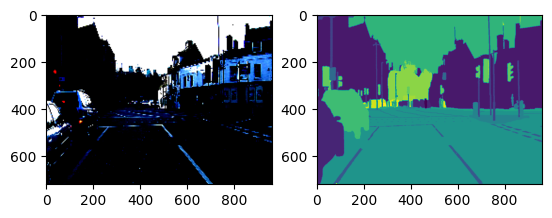

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


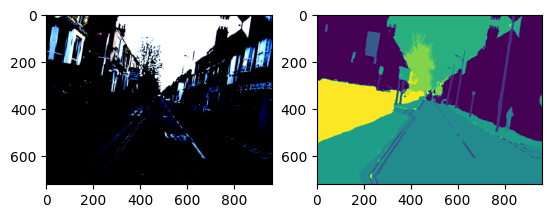

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


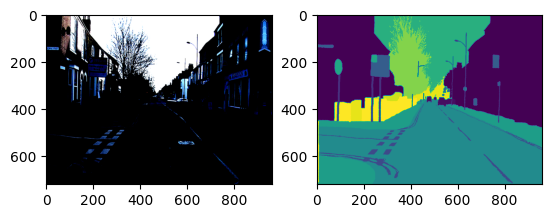

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


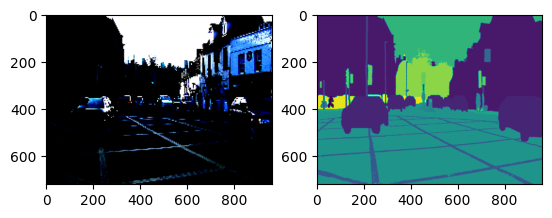

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


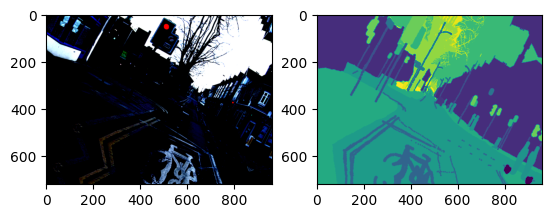

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


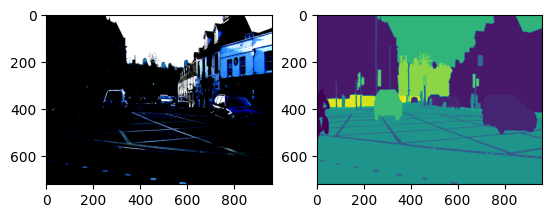

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


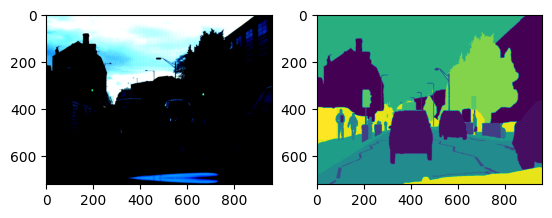

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


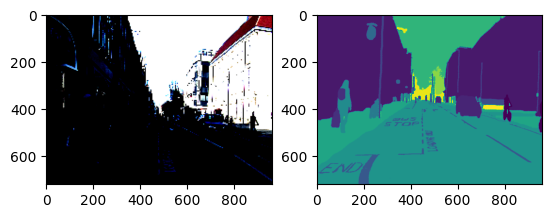

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


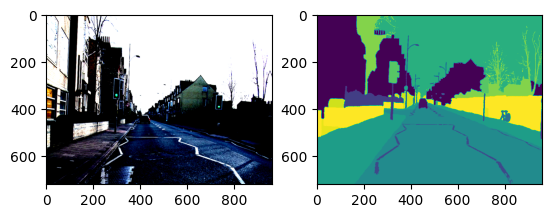

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


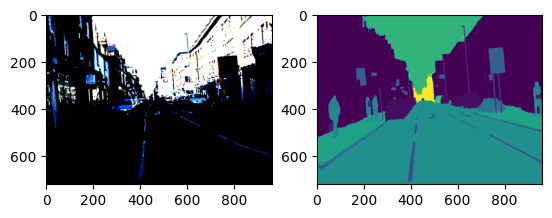

torch.Size([32, 720, 960])
torch.Size([3, 720, 960])


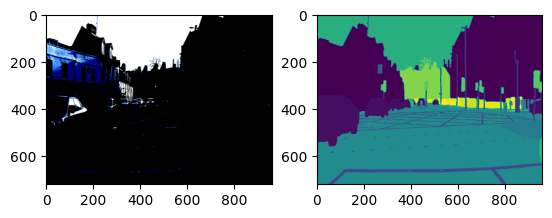

In [13]:
for i in range(len(a[0])): 
    img_x,img_y = a[0][i],a[1][i]
    fig,axs=plt.subplots(1,2)
    print(img_y.shape)
    print(img_x.shape)
    axs[0].imshow(img_x.permute(1, 2, 0).numpy())
    axs[1].imshow(img_y.permute(1, 2, 0).argmax(2).numpy())
    plt.show()

In [14]:
def get_binary(mask):
    binary_mask = torch.zeros_like(mask)

    max_values, max_indices = torch.max(mask, dim=0, keepdim=True)
    binary_mask[max_indices, torch.arange(mask.size(1)).view(-1, 1), torch.arange(mask.size(2))] = 1
    return binary_mask.bool()

# Transfer Learning using Deep Lab V3 ( Mobile Net Backbone )

In [32]:
import torchvision
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', weights=torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)


model.aux_classifier[4] = torch.nn.Conv2d(32,32,kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[0] = torch.nn.Conv2d(40, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.aux_classifier[1] = torch.nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


model.classifier[4] = torch.nn.Conv2d(256,32,kernel_size=(1, 1), stride=(1, 1))
# model.classifier[1] = torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.classifier[0].project[3] = torch.nn.Dropout(p=0.1, inplace=False)
# model=torch.load("/kaggle/working/md5.torch")
opt = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

for param in model.parameters():
    param.requires_grad = False
for param in model.backbone['14'].parameters():
    param.requires_grad = True
for param in model.backbone['15'].parameters():
    param.requires_grad = True
for param in model.backbone['16'].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True
for param in model.aux_classifier.parameters():
    param.requires_grad = True

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [34]:
# import pickle
# with open("md.pkl","rb") as f:
#     model=pickle.load(f)
from torchmetrics.classification import MultilabelAccuracy,MulticlassConfusionMatrix



from torchmetrics.detection.mean_ap import MeanAveragePrecision

model.train()
model = model.to(device)
n_epoch = 50
for e in range(n_epoch):
    
    cur_loss = 0
    train_gen = iter(train_loader)
#     train_acc = MultilabelAccuracy(num_labels=32)
    train_map = MeanAveragePrecision(iou_type="segm")

    for imgs_x,imgs_y in train_gen:
        
        #Reset 
        opt.zero_grad()
        
        #Input 
        x = torch.stack(imgs_x)
        y_train = torch.stack(imgs_y)
        
        
        x=x.to(device)
        y_train=y_train.to(device)
        
        
        #Train
        y_pred = model(x)
        
        
        l1 = loss(y_pred['out'],y_train)
        l2 = loss(y_pred['aux'],y_train)
        l = 0.3*l2 + l1
        
        with torch.no_grad():
            cur_loss += l
            
            y_pred,y_train = y_pred['out'].to("cpu"),y_train.to("cpu")
            
            masks_pred,masks_true = [],[]
            for i in range(y_pred.shape[0]):
                masks_pred.append({
                    "masks": get_binary(y_train[i].to("cpu")),
                    "labels": torch.tensor(list(range(32))),
                    "scores": torch.ones(32)
                })
                masks_true.append({
                    "masks": get_binary(y_pred[i].to("cpu")),
                    "labels": torch.tensor(list(range(32))),
                    "scores": torch.ones(32)
                }) 
                
#             res = train_acc(y_pred,y_train)
            res = train_map(masks_pred,masks_true)
#             print(f'****Epoch [{e}] - Batch Loss : {l.item()} - MAP {res["map"].item()}')

        # Back propagate and optimize
        l.backward()
        opt.step()        
    print(f"----Epoch [{e}] - Loss : {cur_loss} - Map {train_map.compute()}")


----Epoch [0] - Loss : 69.57964376226442 - Map {'map': tensor(0.0324), 'map_50': tensor(0.0757), 'map_75': tensor(0.0220), 'map_small': tensor(0.), 'map_medium': tensor(0.0001), 'map_large': tensor(0.0424), 'mar_1': tensor(0.0546), 'mar_10': tensor(0.0546), 'mar_100': tensor(0.0546), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0012), 'mar_large': tensor(0.0712), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       dtype=torch.int32)}
----Epoch [1] - Loss : 47.52466922185209 - Map {'map': tensor(0.0467), 'map_50': tensor(0.0985), 'map_75': tensor(0.0399), 'map_small': tensor(0.), 'map_medium': tensor(0.0004), 'map_large': tensor(0.1380), 'mar_1': tensor(0.0708), 'mar_10': tensor(0.0708), 'mar_100': tensor(0.0708), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0038), 'mar_large': tensor(0.2088), 'map_per_class'

KeyboardInterrupt: 

In [35]:
import torchvision
torch.save(model,"/kaggle/working/md6_v.torch")

In [ ]:
# import torchvision
# model=torch.load("/kaggle/working/md5_v.torch")

In [36]:
reversed_labels=labels.reset_index().set_index("index")[["r","g","b"]].values
def invert_y(img):
    mm = img.argmax(2).numpy()
    return reversed_labels[mm]

In [37]:
import os
y_valid_annot = []
xpt ="/kaggle/input/camvid/CamVid/val"
for dirname, _, filenames in os.walk('/kaggle/working/transformed_images/val'):
    for filename in filenames:
        y_valid_annot.append(filename)
        
y_valid_annot = pd.Series(y_valid_annot)
X_valid_annot = pd.Series(list(map(lambda d: d.split("_L")[0]+".png",y_valid_annot)))    


In [38]:
valid_dataset = LocalCarImageDataset(X_valid_annot,y_valid_annot,"/kaggle/input/camvid/CamVid/val", "/kaggle/working/transformed_images/val")
valid_loader = DataLoader(valid_dataset,batch_size=16,shuffle=True,collate_fn = collate)

# Validation Set And Confusion Matrix

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 128 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'map': tensor(0.0843), 'map_50': tensor(0.1486), 'map_75': tensor(0.0846), 'map_small': tensor(0.0004), 'map_medium': tensor(0.0479), 'map_large': tensor(0.2618), 'mar_1': tensor(0.1268), 'mar_10': tensor(0.1268), 'mar_100': tensor(0.1268), 'mar_small': tensor(0.0014), 'mar_medium': tensor(0.0597), 'mar_large': tensor(0.3213), 'map_per_class': tensor([0.0000, 0.0000, 0.0103, 0.0000, 0.2733, 0.2656, 0.0000, 0.0000, 0.0000,
        0.0166, 0.0000, 0.0000, 0.0122, 0.0000, 0.0031, 0.0070, 0.0160, 0.7740,
        0.0042, 0.2458, 0.0031, 0.7500, 0.0449, 0.0000, 0.0153, 0.0000, 0.1804,
        0.0031, 0.0000, 0.0425, 0.0028, 0.0275]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.0750, 0.0000, 0.4750, 0.3625, 0.0000, 0.0000, 0.0000,
        0.0875, 0.0000, 0.0000, 0.0688, 0.0000, 0.0250, 0.0375, 0.0812, 0.8250,
        0.0375, 0.4062, 0.0250, 0.7937, 0.1125, 0.0000, 0.0562, 0.0000, 0.3250,
        0.0250, 0.0000, 0.1063, 0.0125, 0.1187]), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  

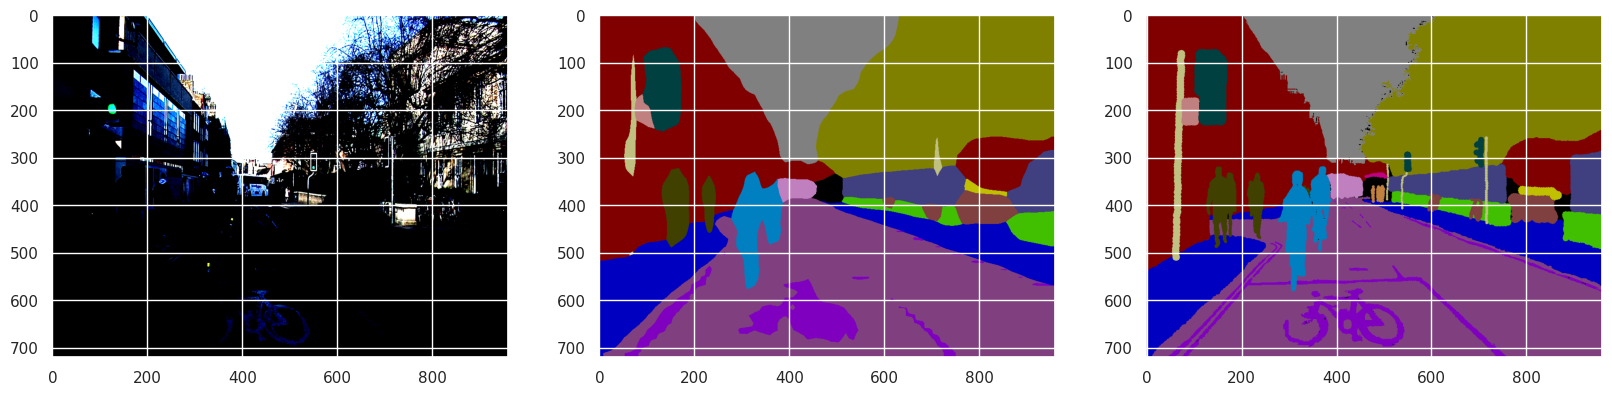

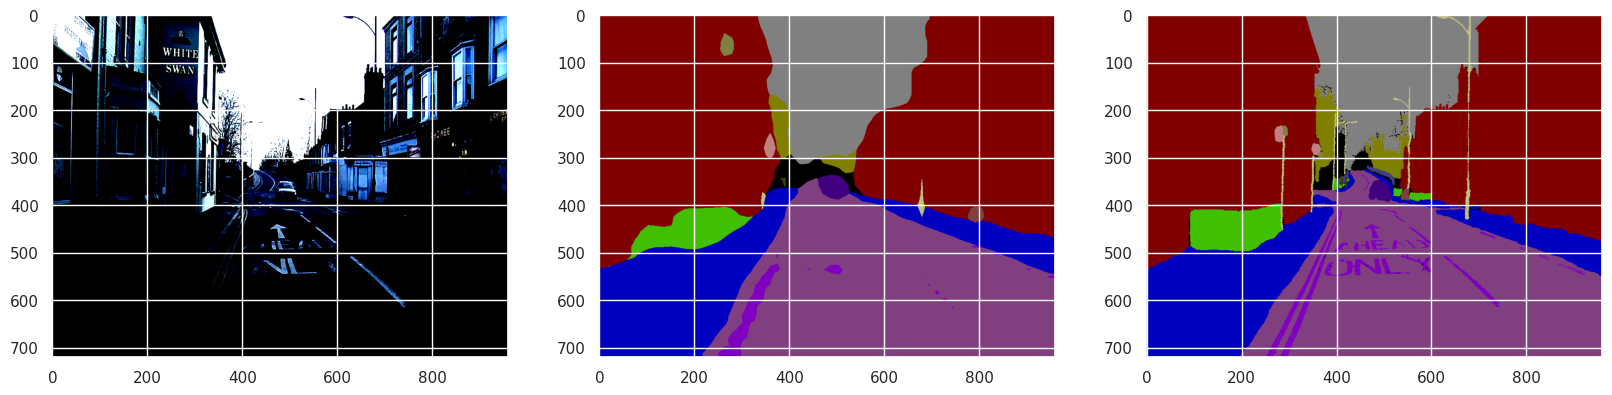

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 160 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'map': tensor(0.1134), 'map_50': tensor(0.1827), 'map_75': tensor(0.1250), 'map_small': tensor(0.), 'map_medium': tensor(0.0369), 'map_large': tensor(0.3049), 'mar_1': tensor(0.1443), 'mar_10': tensor(0.1443), 'mar_100': tensor(0.1443), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0486), 'mar_large': tensor(0.3407), 'map_per_class': tensor([0.0000, 0.0000, 0.0210, 0.0000, 0.7355, 0.2446, 0.0000, 0.0000, 0.0010,
        0.0339, 0.0017, 0.0000, 0.0000, 0.0000, 0.0126, 0.0000, 0.0092, 0.7722,
        0.0011, 0.6430, 0.0023, 0.7309, 0.0000, 0.0000, 0.0542, 0.0000, 0.2966,
        0.0061, 0.0000, 0.0000, 0.0000, 0.0637]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.1125, 0.0000, 0.7750, 0.3500, 0.0000, 0.0000, 0.0063,
        0.1437, 0.0125, 0.0000, 0.0000, 0.0000, 0.0625, 0.0000, 0.0625, 0.8062,
        0.0125, 0.7125, 0.0063, 0.7937, 0.0000, 0.0000, 0.1250, 0.0000, 0.4375,
        0.0500, 0.0000, 0.0000, 0.0000, 0.1500]), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1

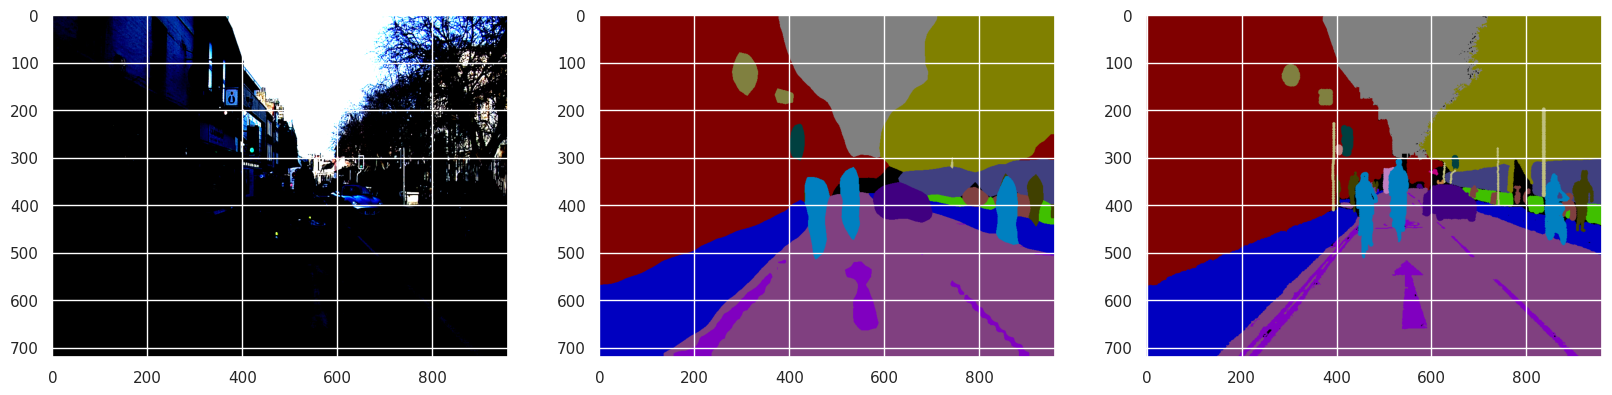

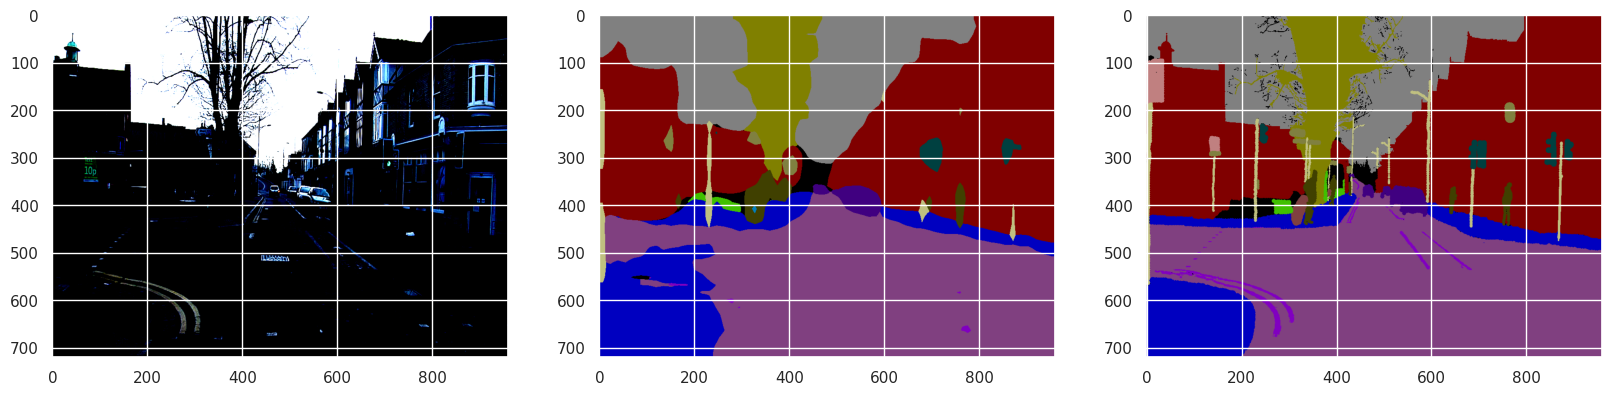

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 256 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'map': tensor(0.1066), 'map_50': tensor(0.1629), 'map_75': tensor(0.1247), 'map_small': tensor(0.), 'map_medium': tensor(0.0456), 'map_large': tensor(0.3308), 'mar_1': tensor(0.1410), 'mar_10': tensor(0.1410), 'mar_100': tensor(0.1410), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0519), 'mar_large': tensor(0.3730), 'map_per_class': tensor([0.0000e+00, 0.0000e+00, 4.5594e-02, 0.0000e+00, 4.7757e-01, 3.1875e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.9000e-02, 0.0000e+00, 0.0000e+00,
        9.9835e-03, 0.0000e+00, 1.8441e-02, 0.0000e+00, 5.6577e-03, 8.6479e-01,
        2.3102e-03, 4.3766e-01, 0.0000e+00, 7.7168e-01, 1.0594e-02, 0.0000e+00,
        1.2046e-02, 0.0000e+00, 2.4746e-01, 1.3490e-02, 0.0000e+00, 6.9307e-03,
        4.3317e-04, 7.7731e-02]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.1250, 0.0000, 0.5750, 0.4563, 0.0000, 0.0000, 0.0000,
        0.2188, 0.0000, 0.0000, 0.0375, 0.0000, 0.0500, 0.0000, 0.0250, 0.9062,
        0.0250, 0.5125, 0.0000, 0.8125, 0.0562

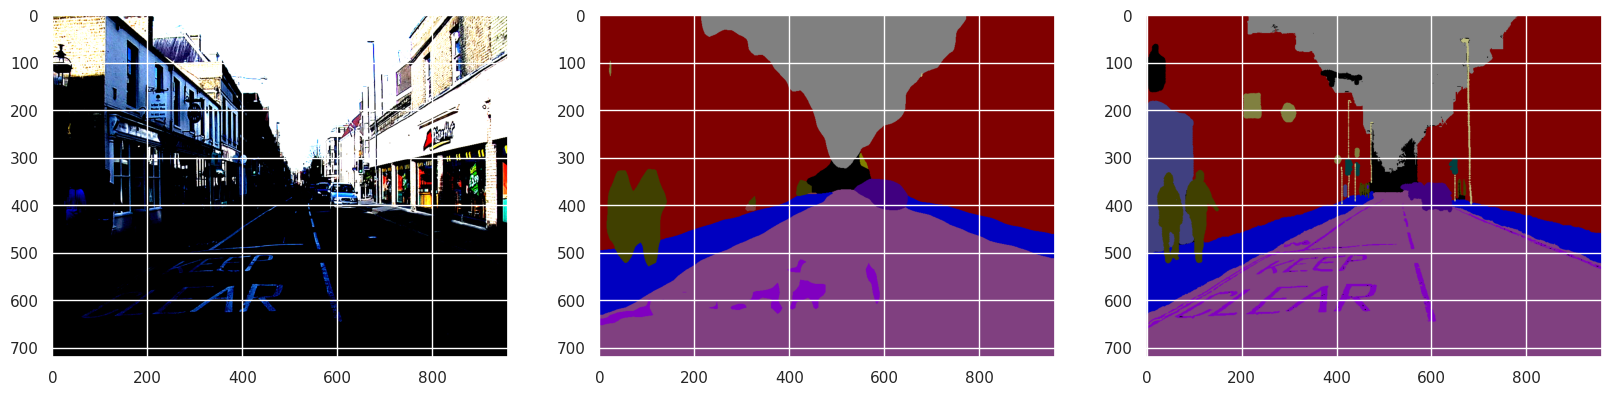

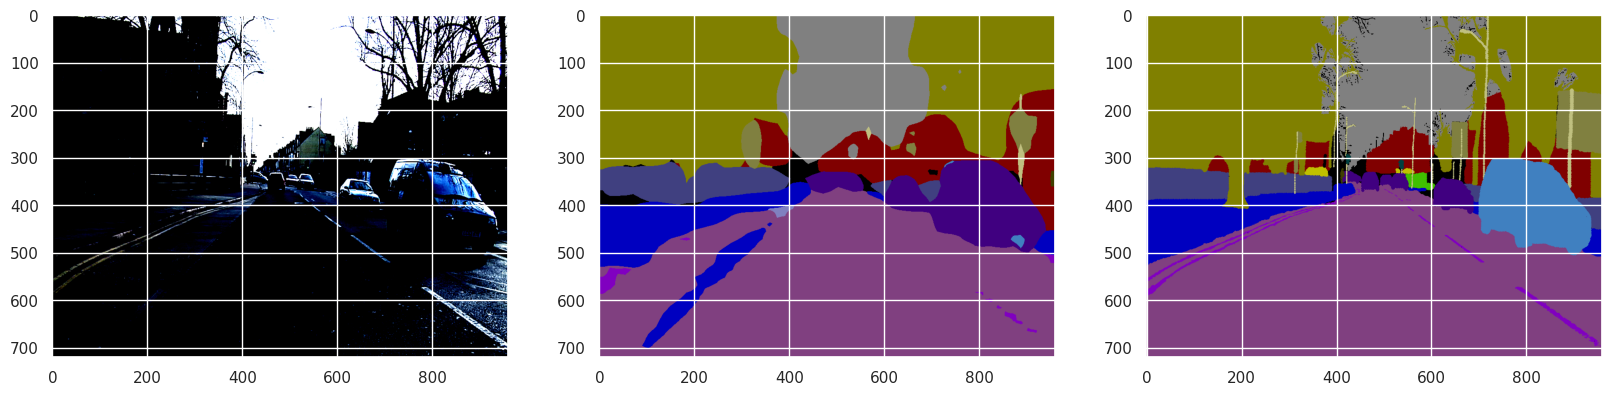

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 192 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'map': tensor(0.1075), 'map_50': tensor(0.1694), 'map_75': tensor(0.1174), 'map_small': tensor(0.0006), 'map_medium': tensor(0.0654), 'map_large': tensor(0.2844), 'mar_1': tensor(0.1432), 'mar_10': tensor(0.1432), 'mar_100': tensor(0.1432), 'mar_small': tensor(0.0012), 'mar_medium': tensor(0.0780), 'mar_large': tensor(0.3298), 'map_per_class': tensor([0.0000, 0.0000, 0.0252, 0.0000, 0.6635, 0.3152, 0.0000, 0.0000, 0.0000,
        0.0119, 0.0000, 0.0000, 0.0046, 0.0000, 0.0189, 0.0000, 0.0431, 0.8151,
        0.0000, 0.2341, 0.0000, 0.8450, 0.0252, 0.0000, 0.0011, 0.0000, 0.3265,
        0.0143, 0.0000, 0.0403, 0.0053, 0.0504]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.1125, 0.0000, 0.7625, 0.4187, 0.0000, 0.0000, 0.0000,
        0.0750, 0.0000, 0.0000, 0.0125, 0.0000, 0.0750, 0.0000, 0.1250, 0.8687,
        0.0000, 0.3625, 0.0000, 0.8750, 0.0875, 0.0000, 0.0125, 0.0000, 0.4625,
        0.0875, 0.0000, 0.0812, 0.0250, 0.1375]), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  

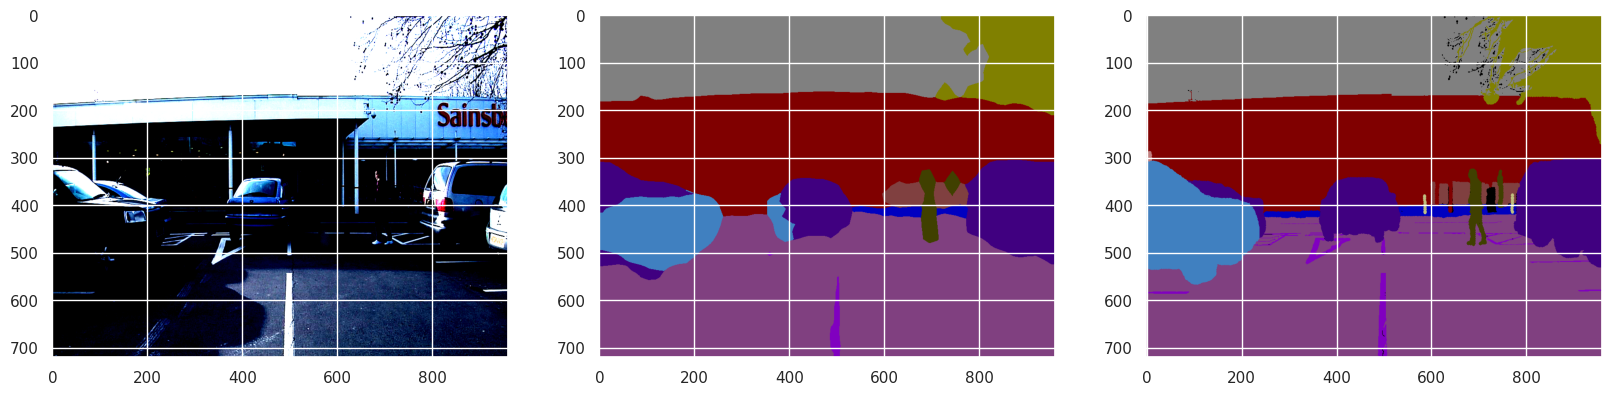

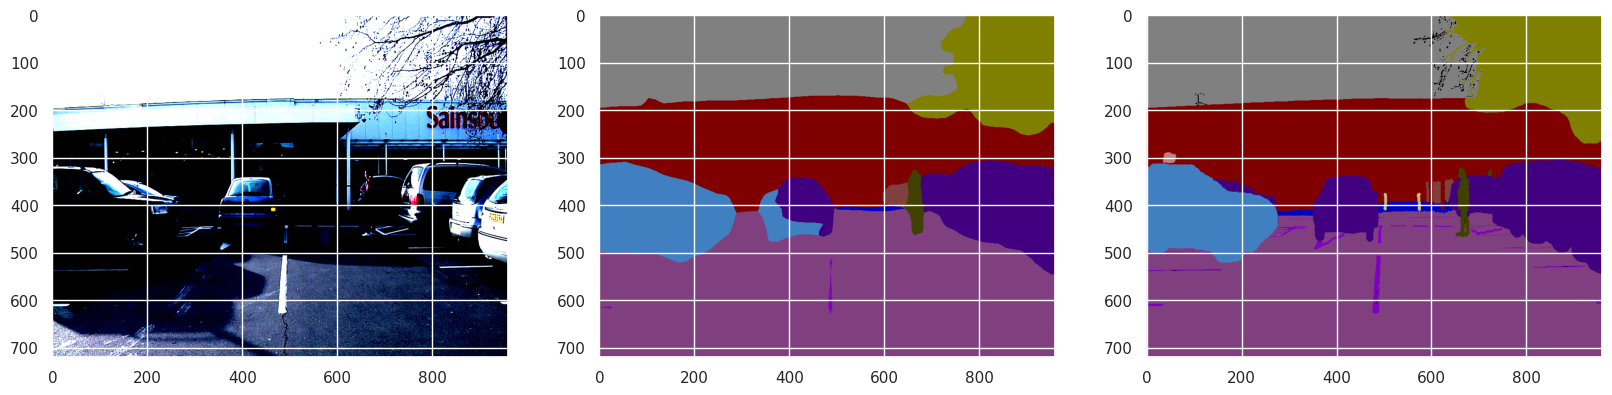

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 96 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


{'map': tensor(0.1052), 'map_50': tensor(0.1569), 'map_75': tensor(0.1230), 'map_small': tensor(0.0005), 'map_medium': tensor(0.0341), 'map_large': tensor(0.3949), 'mar_1': tensor(0.1398), 'mar_10': tensor(0.1398), 'mar_100': tensor(0.1398), 'mar_small': tensor(0.0009), 'mar_medium': tensor(0.0431), 'mar_large': tensor(0.4286), 'map_per_class': tensor([0.0000e+00, 0.0000e+00, 2.4045e-02, 0.0000e+00, 6.8528e-01, 4.0580e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6902e-02, 2.3102e-03, 0.0000e+00,
        1.6657e-02, 0.0000e+00, 1.2601e-03, 0.0000e+00, 1.9678e-02, 8.4788e-01,
        0.0000e+00, 2.2027e-01, 5.7756e-04, 7.9020e-01, 2.4372e-02, 0.0000e+00,
        2.4505e-02, 0.0000e+00, 2.4835e-01, 0.0000e+00, 0.0000e+00, 2.0033e-02,
        1.8482e-03, 1.7698e-02]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.0938, 0.0000, 0.7312, 0.4875, 0.0000, 0.0000, 0.0000,
        0.0750, 0.0063, 0.0000, 0.0750, 0.0000, 0.0125, 0.0000, 0.0688, 0.8687,
        0.0000, 0.4000, 0.0063, 0.8250

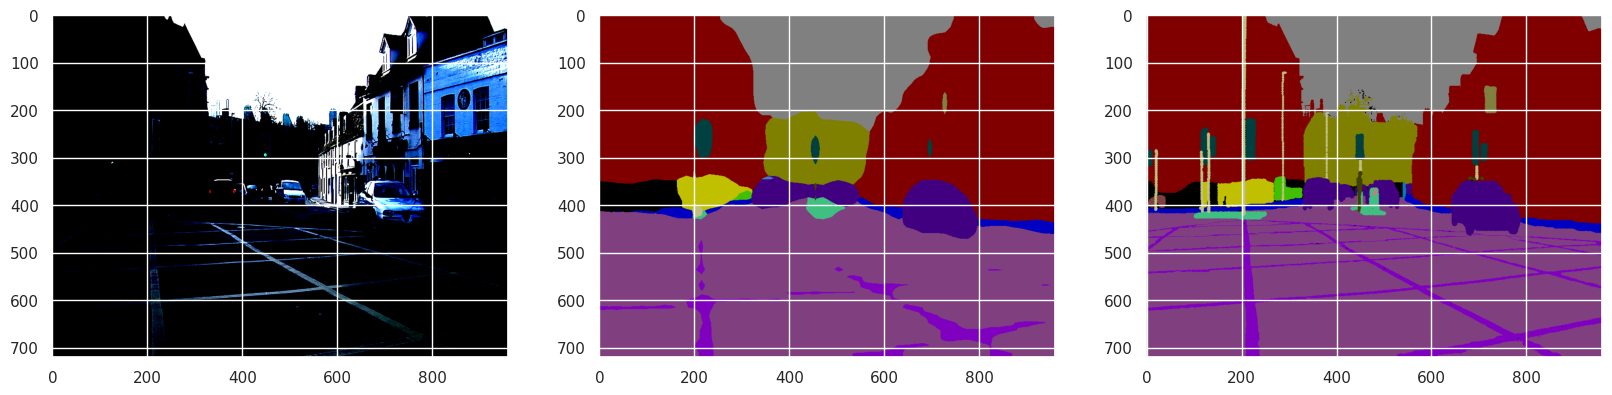

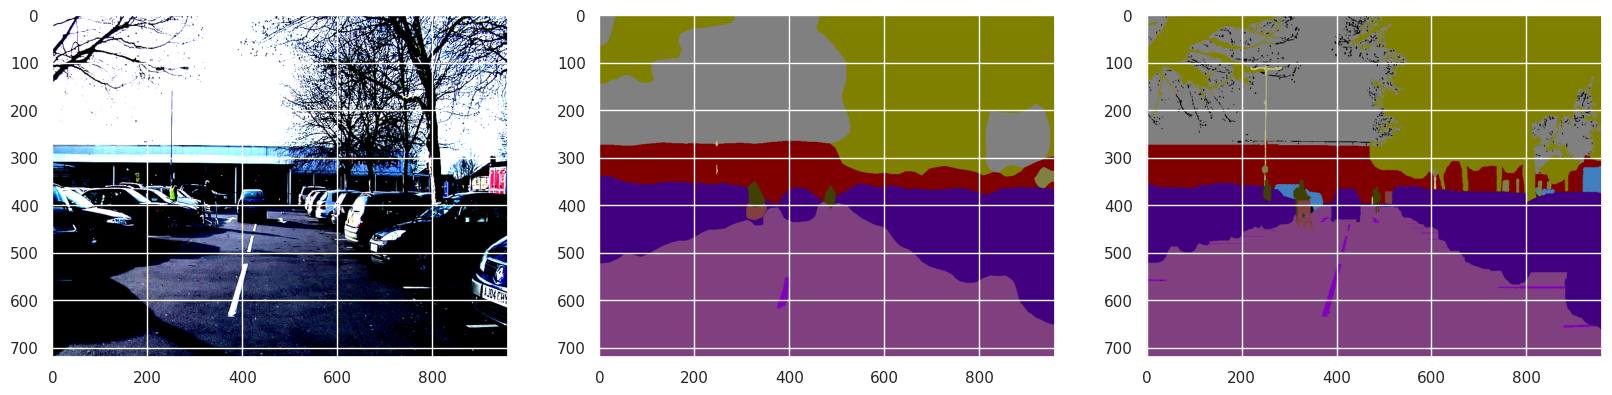

{'map': tensor(0.0999), 'map_50': tensor(0.1640), 'map_75': tensor(0.1106), 'map_small': tensor(0.0013), 'map_medium': tensor(0.0257), 'map_large': tensor(0.3343), 'mar_1': tensor(0.1395), 'mar_10': tensor(0.1395), 'mar_100': tensor(0.1395), 'mar_small': tensor(0.0013), 'mar_medium': tensor(0.0458), 'mar_large': tensor(0.3747), 'map_per_class': tensor([0.0000, 0.0000, 0.0192, 0.0000, 0.6085, 0.2341, 0.0000, 0.0000, 0.0000,
        0.0113, 0.0000, 0.0000, 0.0219, 0.0000, 0.0021, 0.0000, 0.0233, 0.8257,
        0.0069, 0.2310, 0.0000, 0.8147, 0.0322, 0.0000, 0.0198, 0.0000, 0.2645,
        0.0009, 0.0000, 0.0405, 0.0020, 0.0391]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.1063, 0.0000, 0.6812, 0.4000, 0.0000, 0.0000, 0.0000,
        0.0625, 0.0000, 0.0000, 0.1000, 0.0000, 0.0125, 0.0000, 0.0875, 0.8438,
        0.0437, 0.4187, 0.0000, 0.8438, 0.1187, 0.0000, 0.0812, 0.0000, 0.4187,
        0.0125, 0.0000, 0.0812, 0.0250, 0.1250]), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  

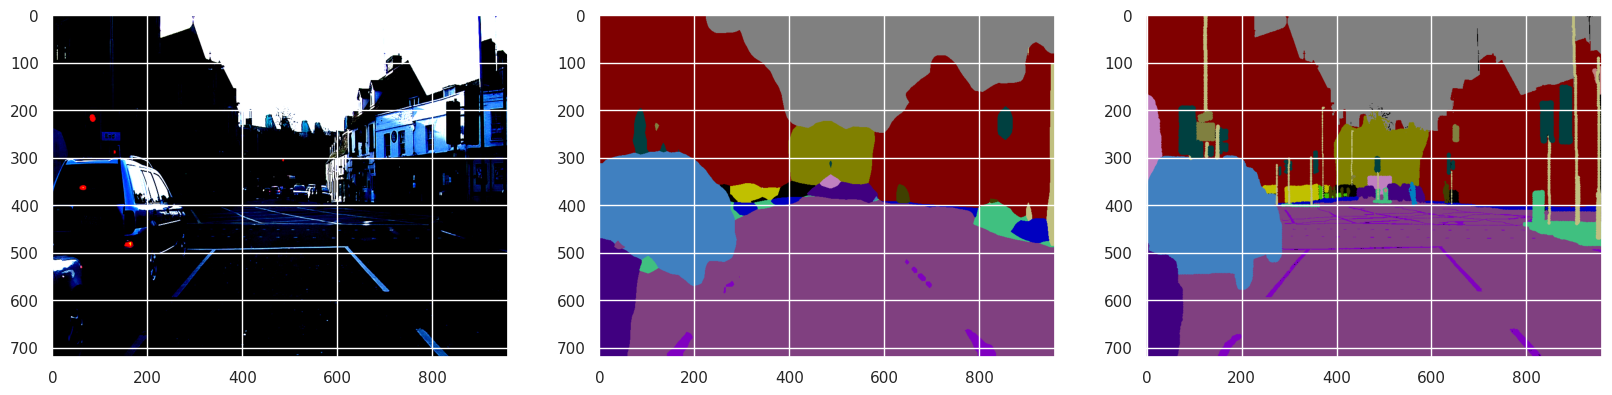

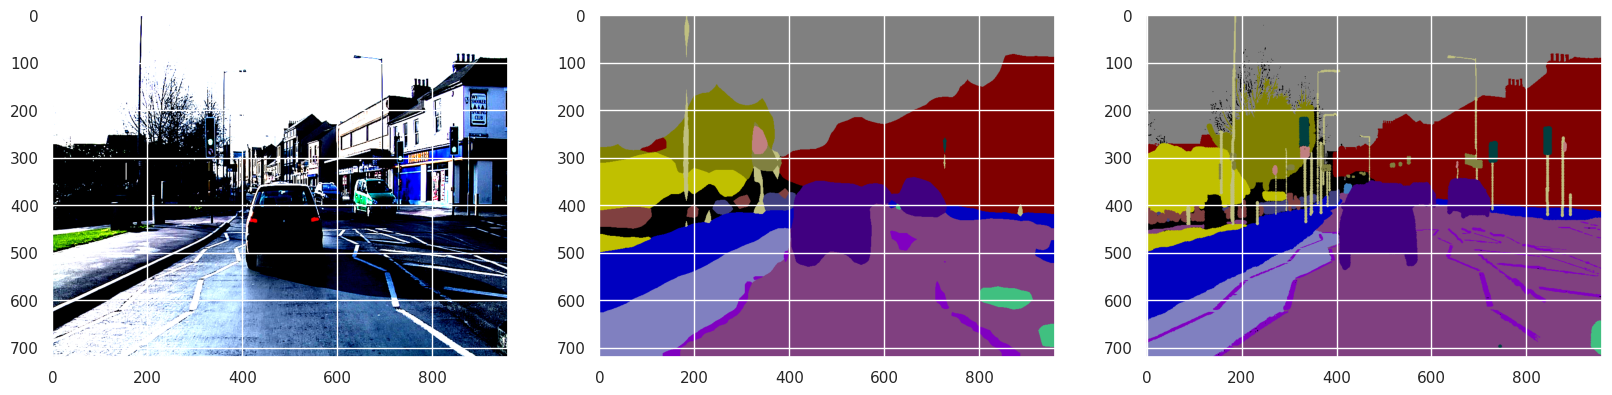

{'map': tensor(0.1583), 'map_50': tensor(0.2262), 'map_75': tensor(0.1748), 'map_small': tensor(0.), 'map_medium': tensor(0.0657), 'map_large': tensor(0.5445), 'mar_1': tensor(0.1648), 'mar_10': tensor(0.1648), 'mar_100': tensor(0.1648), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0656), 'mar_large': tensor(0.5458), 'map_per_class': tensor([0.0000, 0.0000, 0.3545, 0.0000, 0.9000, 0.4416, 0.0000, 0.0000, 0.0000,
        0.2059, 0.0000, 0.0000, 0.0000, 0.0000, 0.1020, 0.0000, 0.0000, 0.7762,
        0.0000, 0.3663, 0.0000, 0.8422, 0.0644, 0.0000, 0.0257, 0.0000, 0.7277,
        0.1030, 0.0000, 0.0000, 0.0000, 0.1545]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.3500, 0.0000, 0.9000, 0.6000, 0.0000, 0.0000, 0.0000,
        0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.7750,
        0.0000, 0.3750, 0.0000, 0.8500, 0.1250, 0.0000, 0.0250, 0.0000, 0.7250,
        0.1000, 0.0000, 0.0000, 0.0000, 0.1500]), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 1

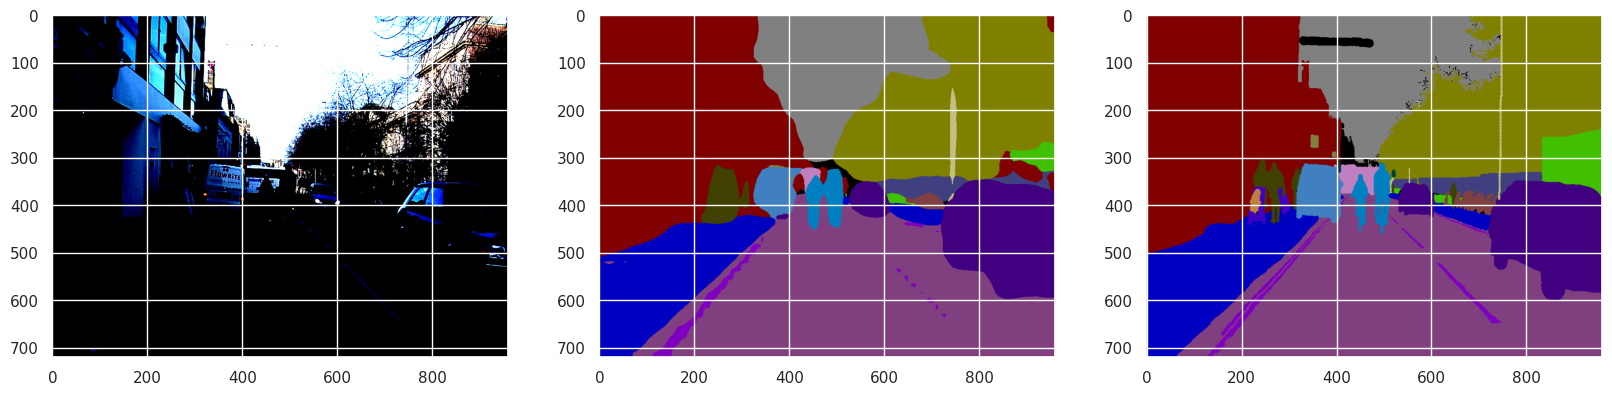

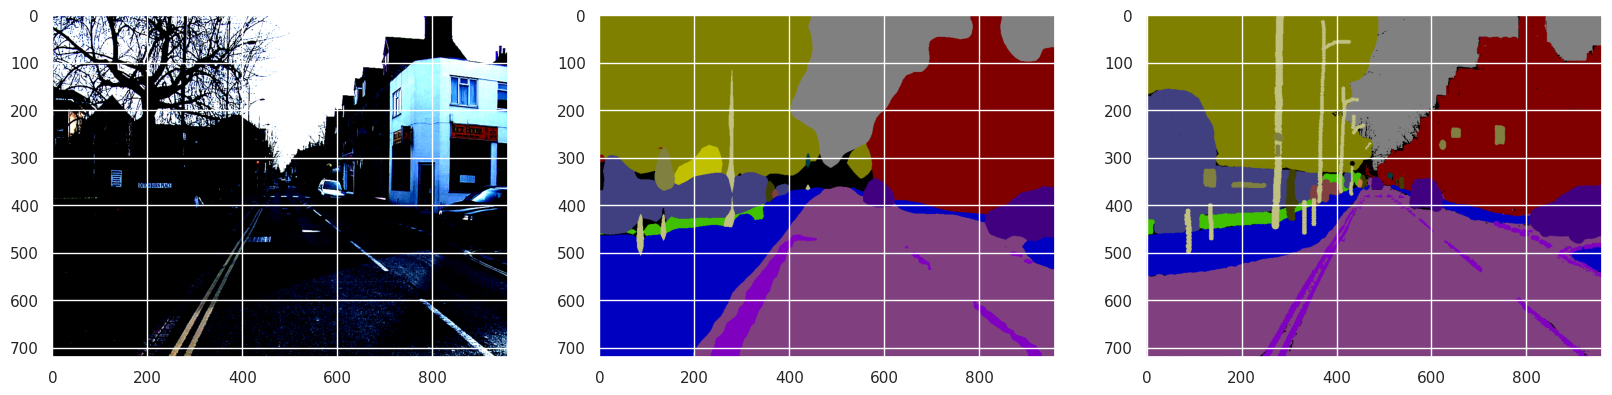

In [39]:
import seaborn as sns
import random

sns.set(rc={'figure.figsize':(20,10)})

from torchmetrics.classification import MultilabelAccuracy,MulticlassConfusionMatrix
from torchmetrics.detection.mean_ap import MeanAveragePrecision
model.to(device)
model.eval()

val_acc = MultilabelAccuracy(num_labels=32)
val_confmat = MulticlassConfusionMatrix(32,normalize ='true')
valid_map = MeanAveragePrecision(iou_type="segm",class_metrics=True)
a,b=None,None
valid_gen = iter(valid_loader)
# valid_gen = iter(train_loader)
with torch.no_grad():
    for imgs_x,imgs_y in valid_gen:

        #Input 
        x = torch.stack(imgs_x)
        y_train = torch.stack(imgs_y)
        y_train=y_train.to(device)


        x=x.to(device)
        y_pred = model(x)["out"]
        
        
        val_acc(y_pred.to("cpu"),y_train.to("cpu"))

        cf = val_confmat(y_pred.permute(2,3,0,1).reshape(-1,32).argmax(1).to("cpu"),y_train.permute(2,3,0,1).reshape(-1,32).argmax(1).to("cpu"))
        a,b = y_pred,imgs_y
        masks_pred,masks_true = [],[]
        
        for i in range(y_pred.shape[0]):
            masks_pred.append({
                "masks": get_binary(a[i].to("cpu")),
                "labels": torch.tensor(list(range(32))),
                "scores": torch.ones(32) / 32.0
            })
            masks_true.append({
                "masks": get_binary(b[i].to("cpu")),
                "labels": torch.tensor(list(range(32)))
            }) 
            
        mp = valid_map(masks_pred,masks_true)
        print(mp)
        for i in random.sample(range(len(imgs_x)),2):
            img_x = x[i]
            img_y = y_pred[i]
            true_y= imgs_y[i]
            fig,axs=plt.subplots(1,3)
            axs[0].imshow(img_x.to("cpu").permute(1, 2, 0).numpy())
            axs[1].imshow(invert_y(img_y.to("cpu").detach().permute(1, 2, 0)))
            axs[2].imshow(invert_y(true_y.to("cpu").detach().permute(1, 2, 0)))
            plt.show()

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: 64 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)  # noqa: B028


General accuracy is : 0.8974891304969788
{'map': tensor(0.0964), 'map_50': tensor(0.1544), 'map_75': tensor(0.1075), 'map_small': tensor(0.0002), 'map_medium': tensor(0.0263), 'map_large': tensor(0.2422), 'mar_1': tensor(0.1401), 'mar_10': tensor(0.1401), 'mar_100': tensor(0.1401), 'mar_small': tensor(0.0008), 'mar_medium': tensor(0.0469), 'mar_large': tensor(0.3009), 'map_per_class': tensor([0.0000e+00, 0.0000e+00, 2.1026e-02, 0.0000e+00, 5.2768e-01, 2.5073e-01,
        0.0000e+00, 0.0000e+00, 8.6096e-05, 2.6187e-02, 1.9457e-04, 0.0000e+00,
        6.5393e-03, 0.0000e+00, 6.6476e-03, 1.6202e-03, 1.4656e-02, 7.9794e-01,
        1.7773e-03, 3.2693e-01, 1.0234e-03, 7.7011e-01, 1.9079e-02, 0.0000e+00,
        1.3959e-02, 0.0000e+00, 2.4223e-01, 4.2634e-03, 0.0000e+00, 1.4431e-02,
        1.4503e-03, 3.7438e-02]), 'mar_100_per_class': tensor([0.0000, 0.0000, 0.1140, 0.0000, 0.6760, 0.4200, 0.0000, 0.0000, 0.0010,
        0.1140, 0.0030, 0.0000, 0.0470, 0.0000, 0.0420, 0.0060, 0.0720, 0.850

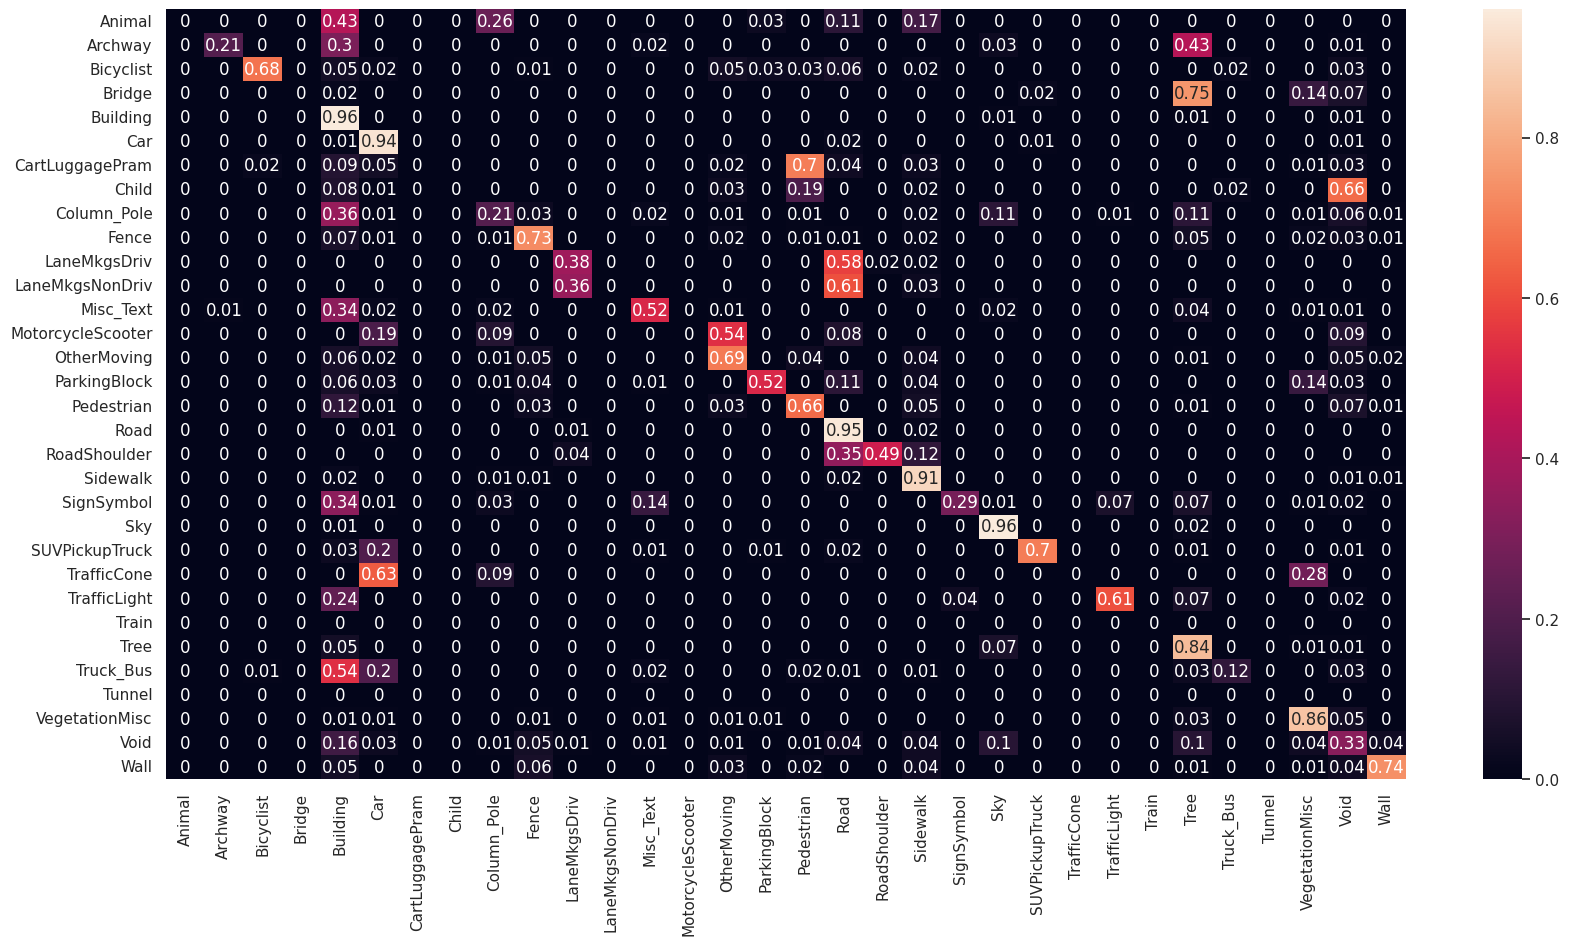

In [40]:
mp = valid_map.compute()
accuracy = val_acc.compute()
sns.heatmap(pd.DataFrame(val_confmat.compute(),columns=labels.name.values,index=labels.name.values).apply(lambda d: d.round(2)),annot=True)
print(f"General accuracy is : {accuracy}")
print(mp)